Take Home Assignment 3

3.0 Install any dependencies if needed


In [1]:
!pip install supervision
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.6/914.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [16]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import time
import supervision as sv

3.1.1 Draw the segmentation mask of the largest car: Use ultralytics library only

In [17]:
img = cv2.imread("demo5_images/cars1.jpg")


0: 416x640 14 cars, 222.7ms
Speed: 4.2ms preprocess, 222.7ms inference, 50.3ms postprocess per image at shape (1, 3, 416, 640)


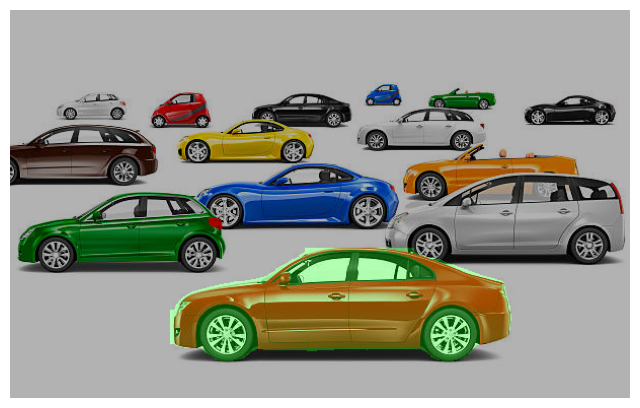

In [18]:
from ultralytics import YOLO
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the YOLOv8 model (use 'yolov8n-seg.pt' for segmentation)
model = YOLO("yolov8n-seg.pt")

# Load the image
image_path = "/content/demo5_images/cars1.jpg"  # Change this to your image path
if not os.path.exists(image_path):
    print(f"Error: Image not found at {image_path}")
    exit()

image = cv2.imread(image_path)
if image is None:
    print("Error: Failed to load image. Check the file path and format.")
    exit()

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform inference
results = model(image_rgb)

# Extract masks and bounding boxes for 'car' class
largest_car_mask = None
max_area = 0

for result in results:
    for mask, box, cls in zip(result.masks.xy, result.boxes.xyxy, result.boxes.cls):
        if int(cls) == 2:  # Class ID for 'car' in COCO dataset
            mask_poly = np.array(mask, np.int32)
            area = cv2.contourArea(mask_poly)
            if area > max_area:
                max_area = area
                largest_car_mask = mask_poly

# Draw the mask on the image
if largest_car_mask is not None:
    mask_overlay = np.zeros_like(image_rgb, dtype=np.uint8)
    cv2.fillPoly(mask_overlay, [largest_car_mask], (0, 255, 0))
    masked_image = cv2.addWeighted(image_rgb, 0.7, mask_overlay, 0.3, 0)

    # Show the image
    plt.figure(figsize=(8, 6))
    plt.imshow(masked_image)
    plt.axis("off")
    plt.show()
else:
    print("No car detected in the image.")


3.1.2 Draw the segmentation mask of the largest car : Use ultralytics + supervision libraries


0: 416x640 14 cars, 216.5ms
Speed: 4.4ms preprocess, 216.5ms inference, 39.4ms postprocess per image at shape (1, 3, 416, 640)


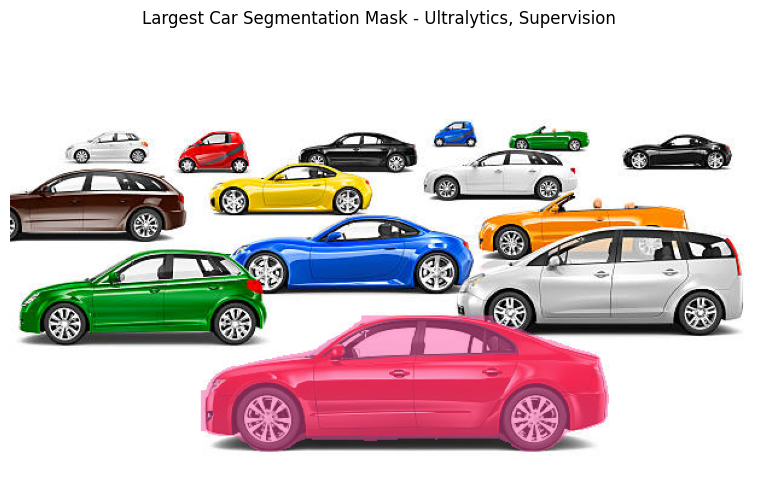

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import supervision as sv

# Load YOLOv8 segmentation model
model = YOLO("yolov8n-seg.pt")

# Load and validate the image
image_path = "demo5_images/cars1.jpg"
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Image file '{image_path}' not found!")

# Convert to RGB for display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Run segmentation model
results = model(img_rgb)

# Initialize mask annotator
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Extract largest car mask
largest_mask, largest_bbox = None, None
max_area = 0

for r in results:
    detections = sv.Detections.from_ultralytics(r)
    for mask, bbox, class_id in zip(detections.mask, detections.xyxy, detections.class_id):
        if class_id == 2:  # Class ID for 'car' in COCO dataset
            area = np.count_nonzero(mask)
            if area > max_area:
                max_area, largest_mask, largest_bbox = area, mask, bbox

# Annotate and display the result
if largest_mask is not None:
    detections = sv.Detections(xyxy=np.array([largest_bbox]), mask=np.array([largest_mask]))
    mask_img = mask_annotator.annotate(scene=img_rgb, detections=detections)

    plt.figure(figsize=(10, 6))
    plt.imshow(mask_img)
    plt.axis("off")
    plt.title("Largest Car Segmentation Mask - Ultralytics, Supervision")
    plt.show()
else:
    print("No car detected in the image.")

3.2 Estimate distance to centroid of chair

Device set to use cpu



0: 384x640 1 chair, 354.5ms
Speed: 6.8ms preprocess, 354.5ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)
Chair centroid: (352, 181), Estimated distance: 146


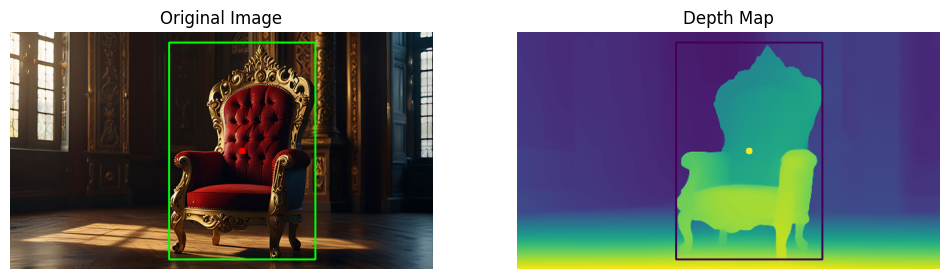

In [31]:
import cv2
import torch
import numpy as np
import supervision as sv
from ultralytics import YOLO
from transformers import pipeline
from PIL import Image
import matplotlib.pyplot as plt

# Load YOLO model for chair detection
detection_model = YOLO("yolov8n.pt")  # Use a suitable YOLO model

# Load Depth Anything V2 Small with GPU acceleration and FP16 precision if available
device = "cuda" if torch.cuda.is_available() else "cpu"
depth_estimator = pipeline(
    task="depth-estimation",
    model="depth-anything/Depth-Anything-V2-Small-hf",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

def detect_chair(image):
    results = detection_model(image)[0]
    return [
        (int(box.xyxy[0][0]), int(box.xyxy[0][1]), int(box.xyxy[0][2]), int(box.xyxy[0][3]),
         ((int(box.xyxy[0][0]) + int(box.xyxy[0][2])) // 2, (int(box.xyxy[0][1]) + int(box.xyxy[0][3])) // 2))
        for box in results.boxes if results.names[int(box.cls.item())] == "chair"
    ]

def estimate_depth(image_path):
    return np.array(depth_estimator(Image.open(image_path))["depth"])  # Convert to NumPy array

def main(image_path):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib
    chairs = detect_chair(image)
    depth_map_np = estimate_depth(image_path)
    depth_map_rgb = np.stack([depth_map_np] * 3, axis=-1)  # Convert to 3-channel for visualization

    if chairs:
        for x1, y1, x2, y2, centroid in chairs:
            depth = depth_map_np[centroid[1], centroid[0]]
            print(f"Chair centroid: {centroid}, Estimated distance: {depth}")
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.circle(image, centroid, 5, (255, 0, 0), -1)
            cv2.rectangle(depth_map_np, (x1, y1), (x2, y2), (0, 255, 255), 2)
            cv2.circle(depth_map_np, centroid, 5, (255, 0, 0), -1)
    else:
        print("No chair detected.")

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(depth_map_np, cmap='viridis')
    axes[1].set_title("Depth Map")
    axes[1].axis("off")

    plt.show()

# Example usage
main("demo5_images/kingChair.jpg")

3.3.1  Draw bounding boxes around the "cars" using supervision.

In [32]:
# Downloads the video file from the google drive link, you'll have to "pip install gdown" first
import gdown

file_id = "1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4"
direct_url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(direct_url, "vehicles_video.mp4", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4
To: /content/vehicles_video.mp4
100%|██████████| 35.3M/35.3M [00:01<00:00, 20.2MB/s]


'vehicles_video.mp4'

In [36]:
model = YOLO("yolo11n.pt")


def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Complete this function

    sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="result_tracking.mp4",
    callback=callback
)

3.3.1 Track the cars. Add the tracker id to the bounding boxes around the cars. Use supervision

In [37]:
import numpy as np
import supervision as sv
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
tracker = sv.ByteTrack()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    results = model(frame)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = tracker.update_with_detections(detections)

    labels = [
        f"#{tracker_id} {results.names[class_id]}"
        for class_id, tracker_id
        in zip(detections.class_id, detections.tracker_id)
    ]

    annotated_frame = box_annotator.annotate(
        frame.copy(), detections=detections)
    return label_annotator.annotate(
        annotated_frame, detections=detections, labels=labels)

sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="result.mp4",
    callback=callback
)

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



0: 384x640 3 cars, 1 truck, 268.0ms
Speed: 9.7ms preprocess, 268.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 292.3ms
Speed: 7.8ms preprocess, 292.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 1 truck, 315.7ms
Speed: 7.6ms preprocess, 315.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 1 truck, 493.3ms
Speed: 24.7ms preprocess, 493.3ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 265.1ms
Speed: 5.6ms preprocess, 265.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 bus, 1 truck, 270.3ms
Speed: 4.6ms preprocess, 270.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 320.9ms
Speed: 5.1ms preprocess, 320.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 310.

KeyboardInterrupt: 

3.3.2 Draw the track traces for the tracked cars. Use supervision

In [38]:
import numpy as np
import supervision as sv
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
tracker = sv.ByteTrack()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    results = model(frame)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = tracker.update_with_detections(detections)

    labels = [
        f"#{tracker_id} {results.names[class_id]}"
        for class_id, tracker_id
        in zip(detections.class_id, detections.tracker_id)
    ]

    annotated_frame = box_annotator.annotate(
        frame.copy(), detections=detections)
    annotated_frame = label_annotator.annotate(
        annotated_frame, detections=detections, labels=labels)
    return trace_annotator.annotate(
        annotated_frame, detections=detections)

sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="result.mp4",
    callback=callback
)

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



0: 384x640 3 cars, 1 truck, 143.3ms
Speed: 5.7ms preprocess, 143.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 144.4ms
Speed: 5.5ms preprocess, 144.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 1 truck, 177.8ms
Speed: 5.2ms preprocess, 177.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 1 truck, 169.9ms
Speed: 5.3ms preprocess, 169.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 157.6ms
Speed: 5.1ms preprocess, 157.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 bus, 1 truck, 154.3ms
Speed: 4.9ms preprocess, 154.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 198.7ms
Speed: 5.5ms preprocess, 198.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 168.9

KeyboardInterrupt: 

Questions:

Explain what "def callback(frame: np.ndarray, _: int) -> np.ndarray:" does.

Answers: Complete this section

The line def callback(frame: np.ndarray, _: int) -> np.ndarray: defines a Python function named callback with the following components:

frame: np.ndarray:

This defines the first parameter of the function named frame. The frame is expected to be a NumPy array (np.ndarray), which typically represents an image or a video frame in computer vision tasks. The np.ndarray type hint indicates that this parameter will be a 2D (grayscale) or 3D (color) array, depending on the image format.
_ : int:

This defines a second parameter, which is named _. The underscore (_) is commonly used to indicate that this parameter is not going to be used within the function body. In Python, it's a convention to use _ for unused parameters or variables. This is often used when the function signature requires a certain number of parameters, but some of them are not needed.
In this case, the parameter is expected to be an integer (int), but it is not used within the function, as per the naming convention.
-> np.ndarray::

This is the return type hint for the function, indicating that the function will return a value of type np.ndarray, which is again a NumPy array. This suggests that the function processes or manipulates the frame (or other data) and returns an updated or modified frame/image in the form of a NumPy array